# Preparation

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn

In [10]:
%matplotlib inline

# Import data and put into desirable data frame

### Extract data from zipfile

In [11]:
import zipfile
zipfile.ZipFile('names.zip').extractall('.')

In [12]:
import os
os.listdir('names')[:5]

['NationalReadMe.pdf',
 'yob1880.txt',
 'yob1881.txt',
 'yob1882.txt',
 'yob1883.txt']

Take a look at one

In [13]:
open('names/yob2011.txt','r').readlines()[:10]

['Sophia,F,21816\n',
 'Isabella,F,19870\n',
 'Emma,F,18777\n',
 'Olivia,F,17294\n',
 'Ava,F,15480\n',
 'Emily,F,14236\n',
 'Abigail,F,13229\n',
 'Madison,F,12360\n',
 'Mia,F,11512\n',
 'Chloe,F,10970\n']

In [14]:
names2011 = pd.read_csv('names/yob2011.txt', names=['name','sex','number'])
  #Have to add names=[], otherwise it will automatically take the first row as column names
    
names2011.head()

,name,sex,number
0,Sophia,F,21816
1,Isabella,F,19870
2,Emma,F,18777
3,Olivia,F,17294
4,Ava,F,15480


### Then we append names from each year into this data frame

In [15]:
names_all = []

for year in range(1880, 2014+1):
    names_all.append(pd.read_csv('names/yob{}.txt'.format(year), names=['name','sex','number']))
    names_all[-1]['year'] = year #Create new column "year" and put value of each year
#names_all contains all data we want, but name, sex, number and year are repeated
#Not one dataframe, but several putting together

#pandas.concat() will concat different data frames into one
allyears = pd.concat(names_all)
allyears.head()

,name,sex,number,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [16]:
allyears.tail()

,name,sex,number,year
33039,Zykeem,M,5,2014
33040,Zymeer,M,5,2014
33041,Zymiere,M,5,2014
33042,Zyran,M,5,2014
33043,Zyrin,M,5,2014


# Name Popularity

### Create new dataframe with multi-indexes: by sex first, then name and year. Also sort the index.

In [17]:
allyears_indexed = allyears.set_index(['sex','name','year']).sort_index()
allyears_indexed.head()

number
sex name      year        
F   Aabha     2011       7
              2012       5
              2014       9
    Aabriella 2008       5
              2014       5

In [18]:
#If we want to look for specific rows, we can use loc() and iloc() to look for the info, for example:
allyears_indexed.loc['F','Mary'].head()

,number
year,
1880,7065
1881,6919
1882,8148
1883,8012
1884,9217


### Now we can build a function to plot the popularity of a name across years

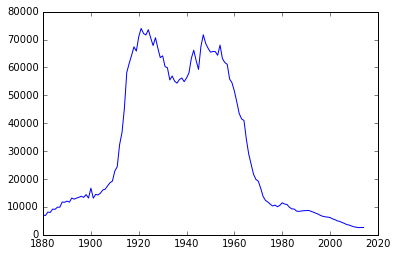

In [19]:
def plotname(sex, name):
    data = allyears_indexed.loc[sex, name]
    pp.plot(data.index, data.values) #data.index is just the year because "year" was used as the index in dataframe above
    
plotname('F','Mary')

### Let's try plot some names together

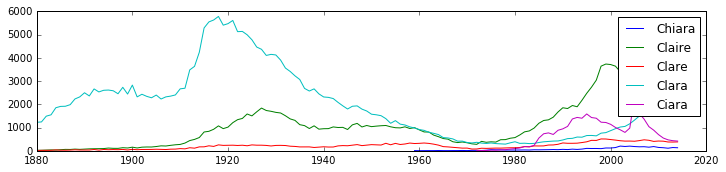

In [20]:
pp.figure(figsize=(12,2.5))

names = ['Chiara','Claire','Clare','Clara','Ciara']
for name in names:
    plotname('F',name)

pp.legend(names)

In [21]:
allyears_indexed.loc['F'].loc[names].head()

number
name   year        
Chiara 1959       9
       1960       5
       1962       8
       1963       8
       1964      12

### Unstack the name index, put it to columns (as values) instead

In [22]:
allyears_indexed.loc['F'].loc[names].unstack(level=0).head()
    #level could be either 0 or 1. If level=1 the table rows and columns would be shifted.

number                           
name Chiara Ciara Claire   Clara Clare
year                                  
1880    NaN   NaN   21.0  1226.0  15.0
1881    NaN   NaN   23.0  1242.0  20.0
1882    NaN   NaN   30.0  1490.0  21.0
1883    NaN   NaN   38.0  1548.0  22.0
1884    NaN   NaN   33.0  1852.0  38.0

### Fill NaN values with 0, then store into a new data frame called variants

In [23]:
variants = allyears_indexed.loc['F'].loc[names].unstack(level=0).fillna(0)

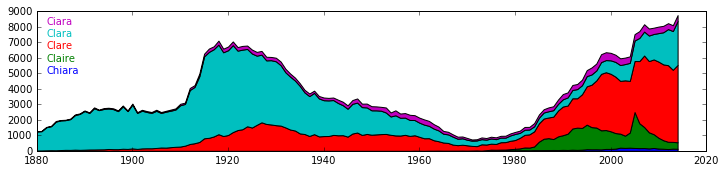

In [24]:
pp.figure(figsize=(12,2.5))
pp.stackplot(variants.index, variants.values.T) #values needs to be transposed here

palette = seaborn.color_palette()

for i,name in enumerate(names):
    pp.text(1882,5000+800*i, name,color = palette[i])

# A Yearly Top 10

In [25]:
#Sort only males in 2008
allyears_indexed.loc['M',:,2008].sort_values('number',ascending=False).head()
   
    #loc[sex, name, year], since name is all, replce by ":"
    #sort_values is to sort the data frame by "number" on descending order

number
sex name    year        
M   Jacob   2008   22568
    Michael 2008   20590
    Ethan   2008   20196
    Joshua  2008   19186
    Daniel  2008   18985

### We want to keep these 5 names as most popular names in 2008, let's make it a new data frame

In [26]:
pop2008 = allyears_indexed.loc['M',:,2008].sort_values('number',ascending=False).head()

#Then we drop columns we don't need by using reset_index().drop()
pop2008.reset_index().drop(['sex','year','number'], axis=1).head()

,name
0,Jacob
1,Michael
2,Ethan
3,Joshua
4,Daniel


### Now we build a function to give top 10 popular names with given gender and year

In [27]:
def topten(sex, year):
    simple = allyears_indexed.loc[sex, :, year].sort_values('number',ascending=False)
    simple = simple.reset_index().drop(['sex', 'year', 'number'], axis=1).head(10)
    
    simple.columns = [year]    #set name for column as year
    simple.index = simple.index + 1  #set index to start from 1 instead of 10 (default)
    return simple

topten('M', 2009)

,2009
1,Jacob
2,Ethan
3,Michael
4,Alexander
5,William
6,Joshua
7,Daniel
8,Jayden
9,Noah
10,Christopher


### Then let's build a function for top 10 names across certain years, in order for comparison

In [28]:
def topten_comparison(sex, year0, year1):
    years = [topten(sex,year) for year in range(year0, year1+1)]
    
    return years[0].join(years[1:])

In [29]:
topten_comparison('M', 2000, 2010)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
1,Jacob,Jacob,Jacob,Jacob,Jacob,Jacob,Jacob,Jacob,Jacob,Jacob,Jacob
2,Michael,Michael,Michael,Michael,Michael,Michael,Michael,Michael,Michael,Ethan,Ethan
3,Matthew,Matthew,Joshua,Joshua,Joshua,Joshua,Joshua,Ethan,Ethan,Michael,Michael
4,Joshua,Joshua,Matthew,Matthew,Matthew,Matthew,Ethan,Joshua,Joshua,Alexander,Jayden
5,Christopher,Christopher,Ethan,Andrew,Ethan,Ethan,Matthew,Daniel,Daniel,William,William
6,Nicholas,Nicholas,Andrew,Ethan,Andrew,Andrew,Daniel,Christopher,Alexander,Joshua,Alexander
7,Andrew,Andrew,Joseph,Joseph,Daniel,Daniel,Andrew,Anthony,William,Daniel,Noah
8,Joseph,Joseph,Christopher,Daniel,William,Anthony,Christopher,William,Anthony,Jayden,Daniel
9,Daniel,Daniel,Nicholas,Christopher,Joseph,Joseph,Anthony,Matthew,Christopher,Noah,Aiden
10,Tyler,William,Daniel,Anthony,Christopher,Christopher,William,Andrew,Matthew,Christopher,Anthony


In [30]:
# Use stack function would put all rows into one series
topten_comparison('F',1985,1995).stack().head()

1  1985    Jessica
   1986    Jessica
   1987    Jessica
   1988    Jessica
   1989    Jessica
dtype: object

In [31]:
#Use value_counts to count the frequency of each name appearing in top 10 for 11 years
topten_comparison('F',1985,1995).stack().value_counts()

Sarah        11
Elizabeth    11
Amanda       11
Ashley       11
Jessica      11
Brittany     10
Stephanie     9
Samantha      8
Jennifer      7
Emily         5
Nicole        4
Heather       3
Megan         3
Taylor        3
Lauren        2
Hannah        1
dtype: int64

### Let's plot the first 6 names for all years

In [32]:
popular = topten_comparison('F',1985,1995).stack().value_counts().index[:6]

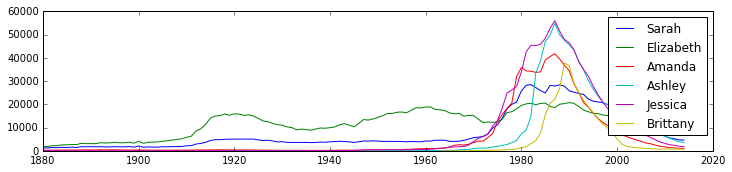

In [33]:
pp.figure(figsize = (12,2.5))

for name in popular:
    plotname('F',name)
    
pp.legend(popular)

# Name Fads (Determine Spikes)

### We want to observe total counts of each name across all years

In [34]:
totals = allyears.groupby(['sex','name'])['number'].sum()

totals.head()

sex  name     
F    Aabha         21
     Aabriella     10
     Aaden          5
     Aadhira       29
     Aadhya       639
Name: number, dtype: int64

### We define spikiness of a name by the following fomula: 

    Spikiness = (sum of (squares)) / sum square = (y1^2 + y2^2 + ... + yn^2) / (y1 + y2 + ... + yn)^2
    
The smaller the number is, the less spiky it is (equals 1/n if all years are equal)

The larger the number is, the more spiky it is (eequals 1 if only one year has non-zero value)

In [35]:
def sumsq(x):
    return sum(x**2)

In [36]:
spikyness = allyears.groupby(['sex','name'])['number'].agg(sumsq) / totals**2
spikyness.head()

#.agg() contains formula for aggregation. In this case we use sum of squares which was defined before.

sex  name     
F    Aabha        0.351474
     Aabriella    0.500000
     Aaden        1.000000
     Aadhira      0.362663
     Aadhya       0.262673
Name: number, dtype: float64

### We define a dataframe with the spikyness computed but only contains names with totals greater than 5000

In [38]:
spiky_common = spikyness[totals > 5000].copy()
spiky_common.sort_values(ascending=False, inplace=True)

#Print the top 5 "spiky" names
spiky_common.head()

sex  name     
M    Iker         0.199368
     Shaquille    0.195689
     Jase         0.182165
F    Adalynn      0.177107
     Harper       0.164827
Name: number, dtype: float64

In [40]:
#Then print top 5 "not spiky" names
spiky_common.tail()

sex  name  
F    Rosa      0.008512
     Mollie    0.008437
M    Ike       0.008310
F    Delia     0.008263
     Louisa    0.007931
Name: number, dtype: float64

### We can plot "Iker" against "Louisa" to observe the pattern

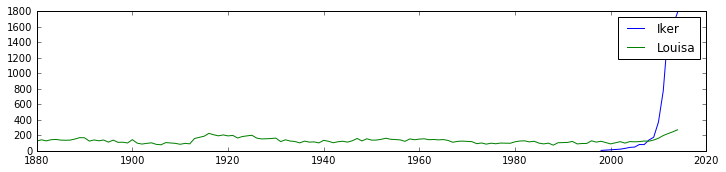

In [48]:
pp.figure(figsize=(12,2.5))

plotname('M','Iker')
plotname('F','Louisa')

pp.legend(['Iker','Louisa'])

### Lastly we want to select names that only used to be popular (not popular for recent 10 years)

In [59]:
totals_recent = allyears[allyears['year'] > 2005].groupby(['sex','name'])['number'].sum()

spiky_common = spikyness[(totals > 5000) & (totals_recent < 1000)].copy()
    #Two Boolean controls here: names over 5000 but no more than 1000 since 2005
spiky_common.sort_values(ascending=False, inplace=True)

spiky_common.head(10)

sex  name     
M    Shaquille    0.195689
F    Katina       0.120872
     Krystle      0.100106
M    Devante      0.099617
F    Khadijah     0.091410
     Shanice      0.089675
     Iesha        0.088810
     Shaniqua     0.087601
     Sheena       0.080751
     Marquita     0.080338
Name: number, dtype: float64

### Finally we plot these names

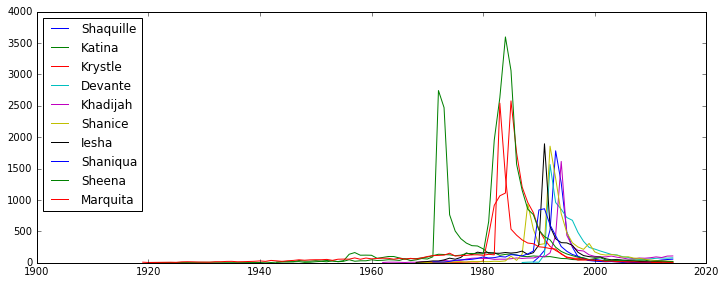

In [76]:
#Define a fads contains sex and name for the top 10 names
fads = spiky_common.head(10).index.values  

pp.figure(figsize = (12, 4.5))

for sex, name in fads:
    plotname(sex, name)

pp.legend([name for sex, name in fads], loc = 'upper left')

# Exercise

### Task 1: Compute the number of times each name was used, seperately for boys and girls

In [31]:
allyears_indexed.head()

number
sex name      year        
F   Aabha     2011       7
              2012       5
              2014       9
    Aabriella 2008       5
              2014       5

In [78]:
totals_F = pd.DataFrame(totals.loc['F'])
totals_M = pd.DataFrame(totals.loc['M'])

totals_F.rename(columns={'number':'F_number'}, inplace=True)
totals_M.rename(columns={'number':'M_number'}, inplace=True)

totals_F and totals_M are dataframes with number of times each name used.

### Task 2: Identify the unisex names where the ratio is between 1-4 and 4-1 

In [82]:
uni_name_all = totals_F.join(totals_M)

uni_name_all.dropna(inplace=True)
uni_name_all.head()

,F_number,M_number
name,,
Aaden,5,3915.0
Aadi,16,667.0
Aadyn,16,387.0
Aalijah,107,155.0
Aaliyah,69833,84.0


In [89]:
#Define ratio for later selection
ratio = uni_name_all['F_number'] / uni_name_all['M_number']

#Create selected dataframe
uni_name_select = uni_name_all[(ratio>0.25) & (ratio<4)]

#Add the column "ratio' into the dataframe
uni_name_select['ratio'] = ratio

uni_name_select.head()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,F_number,M_number,ratio
name,,,
Aalijah,107,155.0,0.690323
Aamari,67,88.0,0.761364
Aaren,282,717.0,0.393305
Aareon,10,33.0,0.303030
Aarian,40,76.0,0.526316


### Task 3: Plot popularity vs. year for the top 10 unisex names

Count total popularity and select top 10

In [96]:
uni_name_select['Total_number'] = uni_name_select['F_number'] + uni_name_select['M_number']
uni_name_select.sort_values(['Total_number'], ascending=False).head(10)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,F_number,M_number,ratio,Total_number
name,,,,
Willie,146129,447759.0,0.326356,593888.0
Jordan,126910,352524.0,0.360004,479434.0
Taylor,308130,107966.0,2.853954,416096.0
Leslie,264054,112533.0,2.346458,376587.0
Jamie,265838,84424.0,3.148844,350262.0
Angel,91734,209691.0,0.437472,301425.0
Lee,62037,229654.0,0.270132,291691.0
Jessie,165614,109317.0,1.514989,274931.0
Marion,187796,71753.0,2.617256,259549.0


Define a list of top 10 names, then plot popularity vs. year

In [98]:
top10_unisex = uni_name_select.sort_values(['Total_number'], ascending=False).head(10).index

top10_unisex

Index(['Willie', 'Jordan', 'Taylor', 'Leslie', 'Jamie', 'Angel', 'Lee',
       'Jessie', 'Marion', 'Dana'],
      dtype='object', name='name')

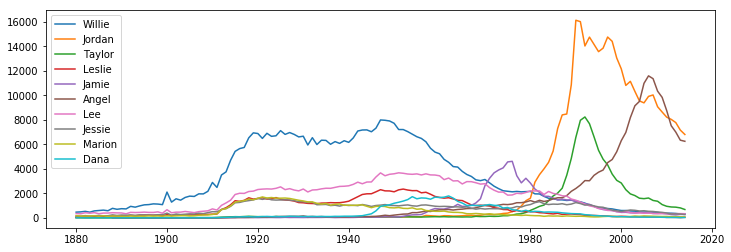

In [100]:
pp.figure(figsize=(12,4))

for name in top10_unisex:
    plotname('M',name)
    
pp.legend(top10_unisex)